In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
np.set_printoptions(formatter={'float': lambda x: "{0:0.4f}".format(x)})
from tueplots import bundles
plt.rcParams.update(bundles.icml2022())
matplotlib.rcParams['font.family'] = "serif"
matplotlib.rcParams['font.serif'] = 'Times new Roman'
matplotlib.rcParams['text.usetex'] = True

In [3]:
print(plt.rcParams['figure.figsize'])
figwidth = plt.rcParams['figure.figsize'][0]
figheight = plt.rcParams['figure.figsize'][1]
print(figheight)
print(figwidth)

[3.25, 2.0086104634371584]
2.0086104634371584
3.25


# The limitations of the LB approximation

Create multiple examples. A working case, a standard case and an extreme case. For every version, show the true distribution, the classic LB and the normalized LB

In [4]:
def correct_mu(mu, Sigma):
    return(mu - Sigma.sum(0) * mu.sum() / Sigma.sum())

def correct_Sigma(mu, Sigma):
    return(Sigma - np.outer(Sigma.sum(0), Sigma.sum(1)) / Sigma.sum())

def get_alpha_from_Normal(mu, Sigma):
    K = len(mu)
    sum_exp = np.sum(np.exp(-1*np.array(mu)))
    alpha = 1/np.diag(Sigma) * (1 - 2/K + np.exp(mu)/(K**2) * sum_exp)
        
    return(np.array(alpha))

from scipy.stats import norm
from scipy.special import gamma as gamma_func
from scipy.special import beta as beta_func

"""Transforms"""
def logit_transform(theta):
    return(np.log(theta/(1-theta)))

def logit_derivative(x):
    return(1/x + 1/(1-x))

def logistic_transform(a):
    return(1 / (1 + np.exp(-a)))

def logistic_derivative(x):
    return(logistic_transform(x) * (1- logistic_transform(x)))

def alpha_from_mu_var(mu, var):
    return((np.exp(mu) + 1) / var)

def beta_from_mu_var(mu, var):
    return((np.exp(-mu) + 1) / var)

def beta_pdf(x, a, b):
    nom = x ** (a-1) * (1 - x) ** (b-1)
    denom = beta_func(a, b)
    return(nom/denom)

def beta_t_logit_pdf(x, a, b):
    x_t = logistic_transform(x)
    nom = (x_t) ** (a) * (1- x_t) ** (b)
    denom = beta_func(a, b)
    return((nom/denom))

def beta_mu(a, b):
    return((a-1)/(a+b-2))

def beta_var(a, b):
    return(((a-1)*(b-1))/(a+b-2)**3)

"""transform: logit"""

def beta_t_logit_mu(a,b):
    return(np.log(a/b))

def beta_t_logit_var(a,b):
    return((a+b)/(a*b))

def logit_normal_back(x, mu, sigma):
    x_ = logit_transform(x)
    return(norm.pdf(x_, mu, sigma) * logit_derivative(x))

In [5]:
def plot_LB_limits(mu, Sigma, x_lb=-10, x_ub=10, x2_lb=-10, x2_ub=10, mode='beta', legend=False, filename="delete.pdf"):
    
    assert(mode in ["beta", "2D_dir"])
    
    #apply the sum(y) = 0 correction
    mu = correct_mu(mu, Sigma)
    Sigma = correct_Sigma(mu, Sigma)
    K = len(mu)
    print("mu after correction: ", mu)
    print("Sigma after correction: ", Sigma)
    
    if mode == "2D_dir":
        alpha = get_alpha_from_Normal(mu, Sigma)
        print("alpha: ", alpha)
        a, b = alpha[0], alpha[1]
        m, s = mu[0], np.sqrt(Sigma[0][0])

        ### do the normalization
        Sigma_diag_mean = np.diag(Sigma).mean() / np.sqrt(K/2)
        mu_hat = mu / np.sqrt(Sigma_diag_mean)
        Sigma_hat = Sigma / Sigma_diag_mean

        alpha_hat = get_alpha_from_Normal(mu_hat, Sigma_hat)
        print("alpha_hat: ", alpha_hat)
        a_hat, b_hat = alpha_hat[0], alpha_hat[1]
        m_hat, s_hat = mu_hat[0], np.sqrt(Sigma_hat[0][0])
        
    elif mode == "beta":
        m, v = mu[0], Sigma[0][0]
        a, b = alpha_from_mu_var(m, v), beta_from_mu_var(m, v)
        s = np.sqrt(v)
        
        ### do the normalization
        Sigma_diag_mean = np.diag(Sigma).mean() #/ np.sqrt(K/2)
        mu_hat = mu / np.sqrt(Sigma_diag_mean)
        Sigma_hat = Sigma / Sigma_diag_mean
        
        m_hat, v_hat = mu_hat[0], Sigma_hat[0][0]
        a_hat, b_hat = alpha_from_mu_var(m_hat, v_hat), beta_from_mu_var(m_hat, v_hat)
        s_hat = np.sqrt(v_hat)
        

    x_t = np.linspace(x_lb,x_ub, 1000 +1)
    
    y_t_logit = beta_t_logit_pdf(x_t, a, b)
    LP_approx_t_logit = norm.pdf(x_t, m, s)
    
    x_t = np.linspace(x_lb,x_ub, 1000 +1)
    x_t2 = np.linspace(x2_lb,x2_ub, 1000 +1)
    
    ## add logistic derivative
    x_t_logistic_derivative = logistic_derivative(x_t)
    x_t2_logistic_derivative = logistic_derivative(x_t2)
    
    y_t_logit_hat = beta_t_logit_pdf(x_t2, a_hat, b_hat)
    LP_approx_t_logit_hat = norm.pdf(x_t2, m_hat, s_hat)
    

    fig, axs = plt.subplots(nrows=1, ncols=2, dpi=300, figsize=(figwidth, 0.6*figheight))
    lw_size = 1
    
    #plot beta distribution in the transformed basis
    axs[0].plot(x_t, y_t_logit, '-', color='firebrick', lw=lw_size, label="$\mathcal{B}$")
    axs[0].plot(x_t, LP_approx_t_logit, '--', color='firebrick', lw=lw_size, label="$\mathcal{N}$")
    axs[0].plot(x_t, x_t_logistic_derivative, ':', color="black", lw=lw_size, label="$\partial\sigma(x)$")
    #axs[0].set_xlabel('x')
    axs[0].set_yticklabels([])
    axs[0].set_yticks([])
    if legend:
        leg = axs[0].legend();
        leg.legendHandles[0].set_color('grey')
        leg.legendHandles[1].set_color('grey')

    #plot backwards transformation of the LPA from the transformed to the standard basis
    axs[1].plot(x_t2, y_t_logit_hat, '-', lw=lw_size, color='cornflowerblue')
    axs[1].plot(x_t2, LP_approx_t_logit_hat, '--', lw=lw_size, color='cornflowerblue')
    axs[1].plot(x_t2, x_t2_logistic_derivative, ':', color="black", lw=lw_size)
    axs[1].set_yticklabels([])
    axs[1].set_yticks([])

    #plt.tight_layout()
    
    plt.savefig(filename)
    plt.show();
    

mu after correction:  [0.2000 -0.2000]
Sigma after correction:  [[0.5000 -0.5000]
 [-0.5000 0.5000]]


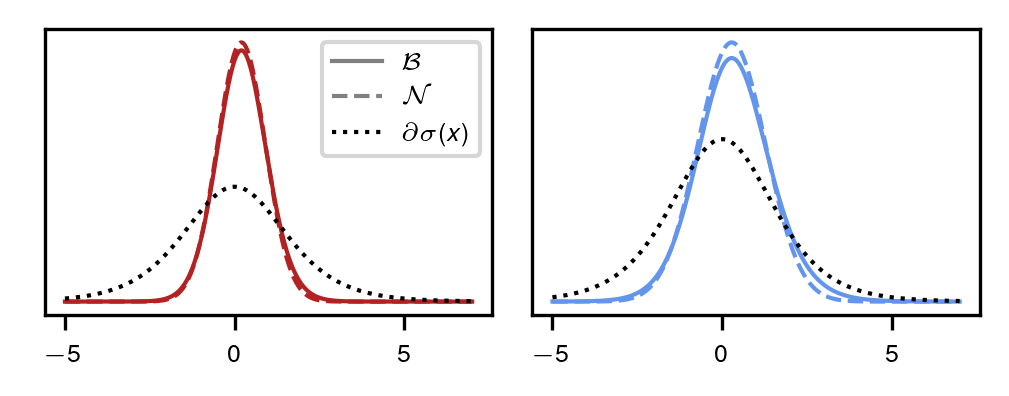

In [6]:
## simple example

mu1 = np.array([0.2,-0.2])
Sigma1 = np.array([[1, 0],
                   [0, 1]])

plot_LB_limits(mu1, Sigma1, -5, 7, -5, 7, mode='beta', legend=True, filename="LB_2D_limits_low_var.pdf")

mu after correction:  [-1.3946 1.3946]
Sigma after correction:  [[3.8748 -3.8748]
 [-3.8748 3.8748]]


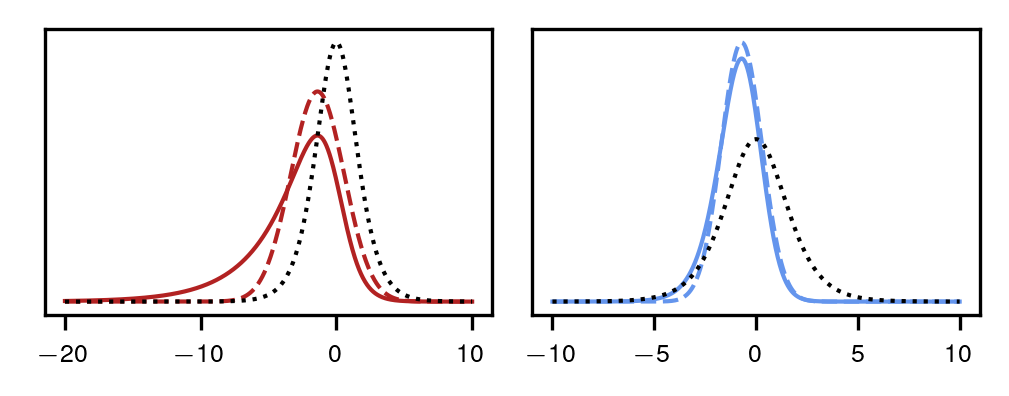

In [7]:
## real in-dist example

mu2 = np.array([ -1.3802,  1.4090])
Sigma2 = np.array([[7.7495, 0.0000],
                   [0.0000, 7.7495]])

plot_LB_limits(mu2, Sigma2, -20, 10, -10, 10, mode='beta', filename='LB_2D_limits_medium_var.pdf')

mu after correction:  [7.1752 -7.1752]
Sigma after correction:  [[7.9930 -7.9930]
 [-7.9930 7.9930]]


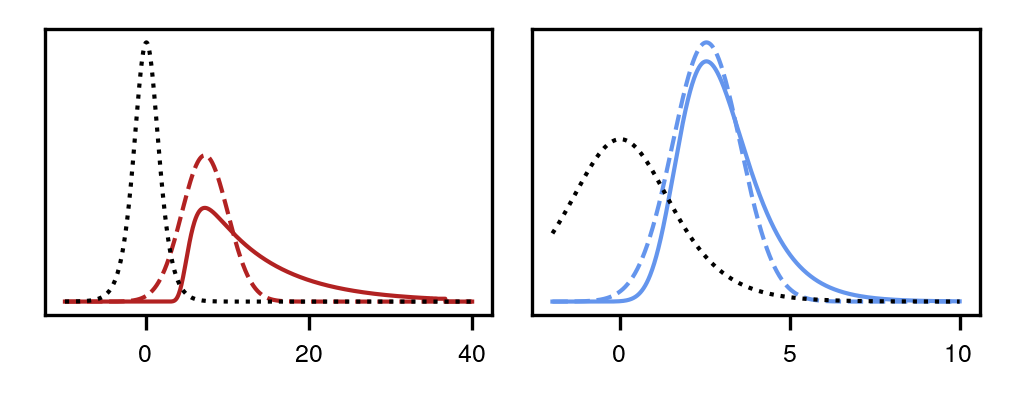

In [8]:
## real OOD example

mu3 = np.array([ 5.8471, -8.5032])
Sigma3 = 0.012* np.array([[1332.1691, 0],
                   [0, 1332.1691]])

plot_LB_limits(mu3, Sigma3, -10, 40, -2, 10, mode='beta', filename="LB_2D_limits_high_var.pdf")

# Investigate the Beta part of this limitation

In [9]:
from scipy.stats import beta, norm

def plot_LB_limits_simplex(mu, Sigma, x_lb=-10, x_ub=10, x2_lb=-10, x2_ub=10, mode='beta', legend=False, filename="delete.pdf"):
    
    assert(mode in ["beta", "2D_dir"])
    
    #apply the sum(y) = 0 correction
    mu_c = correct_mu(mu, Sigma)
    Sigma_c = correct_Sigma(mu, Sigma)
    K = len(mu)
    print("mu after correction: ", mu_c)
    print("Sigma after correction: ", Sigma_c)
    
    if mode == "2D_dir":
        alpha = get_alpha_from_Normal(mu_c, Sigma_c)
        print("alpha: ", alpha)
        a, b = alpha[0], alpha[1]
        m, v = mu_c[0], Sigma_c[0][0]
        s = np.sqrt(v)

        ### do the normalization
        Sigma_diag_mean = np.diag(Sigma_c).mean() / np.sqrt(K/2)
        mu_hat = mu_c / np.sqrt(Sigma_diag_mean)
        Sigma_hat = Sigma_c / Sigma_diag_mean

        alpha_hat = get_alpha_from_Normal(mu_hat, Sigma_hat)
        print("alpha_hat: ", alpha_hat)
        a_hat, b_hat = alpha_hat[0], alpha_hat[1]
        m_hat, v_hat = mu_hat[0], Sigma_hat[0][0]
        s_hat = np.sqrt(v_hat)
        
    elif mode == "beta":
        m, v = mu[0], Sigma[0][0]
        a, b = alpha_from_mu_var(m, v), beta_from_mu_var(m, v)
        s = np.sqrt(v)
        
        ### do the normalization
        Sigma_diag_mean = np.diag(Sigma).mean() #/ np.sqrt(K/2)
        mu_hat = mu / np.sqrt(Sigma_diag_mean)
        Sigma_hat = Sigma / Sigma_diag_mean
        
        m_hat, v_hat = mu_hat[0], Sigma_hat[0][0]
        a_hat, b_hat = alpha_from_mu_var(m_hat, v_hat), beta_from_mu_var(m_hat, v_hat)
        s_hat = np.sqrt(v_hat)
        

    x = np.linspace(0,1, 1000 +1)
    x_t = np.linspace(x_lb,x_ub, 1000 +1)
    
    y = beta.pdf(x, a, b)
    y_t_logit = beta_t_logit_pdf(x_t, a, b)
    LP_approx_t_logit = norm.pdf(x_t, m, s)
    
    x_t = np.linspace(x_lb,x_ub, 1000 +1)
    x_t2 = np.linspace(x2_lb,x2_ub, 1000 +1)
    
    y_hat = beta.pdf(x, a_hat, b_hat)
    y_t_logit_hat = beta_t_logit_pdf(x_t2, a_hat, b_hat)
    LP_approx_t_logit_hat = norm.pdf(x_t2, m_hat, s_hat)
    
    ### compare to samples
    mu_og = mu[0]
    v_og = Sigma[0][0]
    norm_samples = norm(mu_og, np.sqrt(v)).rvs(10000)
    norm_samples_hat = norm(m_hat, np.sqrt(v_hat)).rvs(10000)
    norm_samples_logistic = logistic_transform(norm_samples)
    norm_samples_hat_logistic = logistic_transform(norm_samples_hat)

    fig, axs = plt.subplots(nrows=1, ncols=3, dpi=300, figsize=(figwidth, 0.6*figheight))
    lw_size = 1
    
    #plot beta distribution in the transformed basis
    axs[0].plot(x_t, y_t_logit, '-', color='firebrick', label="$\mathcal{B}$")
    axs[0].plot(x_t, LP_approx_t_logit, '--', color='firebrick', label="$\mathcal{N}$")
    #axs[0].set_xlabel('x')
    axs[0].set_yticklabels([])
    axs[0].set_yticks([])
    if legend:
        leg = axs[0].legend();
        leg.legendHandles[0].set_color('grey')
        leg.legendHandles[1].set_color('grey')

    #plot backwards transformation of the LPA from the transformed to the standard basis
    axs[1].plot(x_t2, y_t_logit_hat, '-', color='cornflowerblue')
    axs[1].plot(x_t2, LP_approx_t_logit_hat, '--', color='cornflowerblue')
    axs[1].set_yticklabels([])
    axs[1].set_yticks([])
    
    #plot resulting beta distribution
    axs[2].plot(x, y, lw=1, color="firebrick")
    axs[2].plot(x, y_hat, lw=1, color="cornflowerblue")
    axs[2].hist(norm_samples_logistic, bins=100, density=True)
    #axs[2].hist(norm_samples_hat_logistic, bins=100, density=True)

    #plt.tight_layout()
    
    plt.savefig(filename)
    plt.show();
    

mu after correction:  [-4.5000 4.5000]
Sigma after correction:  [[10.0000 -10.0000]
 [-10.0000 10.0000]]


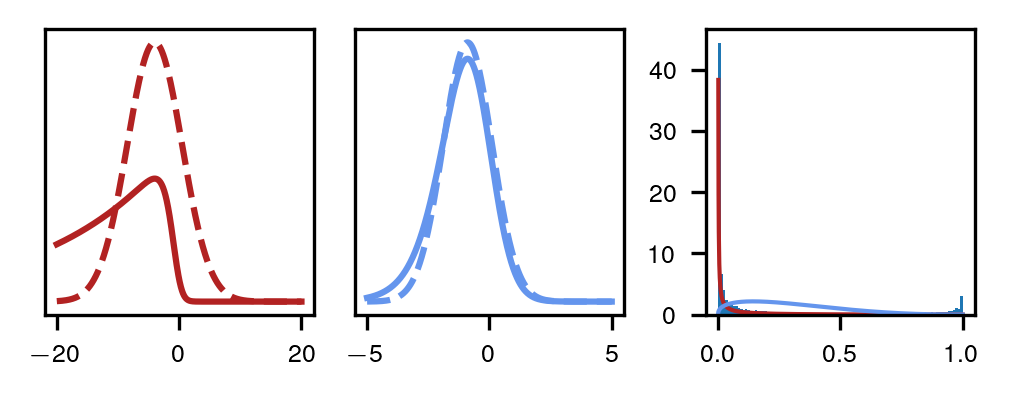

In [10]:
## real OOD example
mu4 = np.array([-4, 5])
Sigma4 = np.eye(2) * 20
plot_LB_limits_simplex(mu4, Sigma4, -20, 20, -5, 5, mode='beta', filename="delete.pdf")

mu after correction:  [0.2000 -0.2000]
Sigma after correction:  [[0.5000 -0.5000]
 [-0.5000 0.5000]]


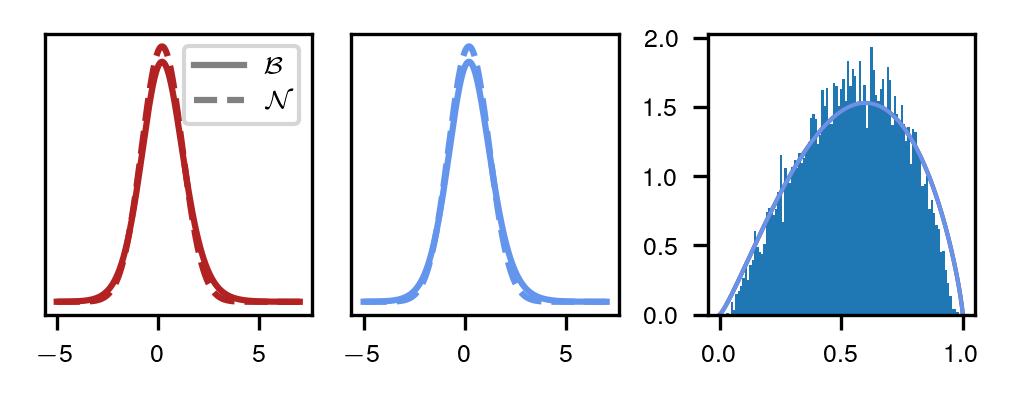

In [11]:
## real OOD example
plot_LB_limits_simplex(mu1, Sigma1, -5, 7, -5, 7, mode='beta', legend=True, filename="delete.pdf")

mu after correction:  [7.1752 -7.1752]
Sigma after correction:  [[7.9930 -7.9930]
 [-7.9930 7.9930]]


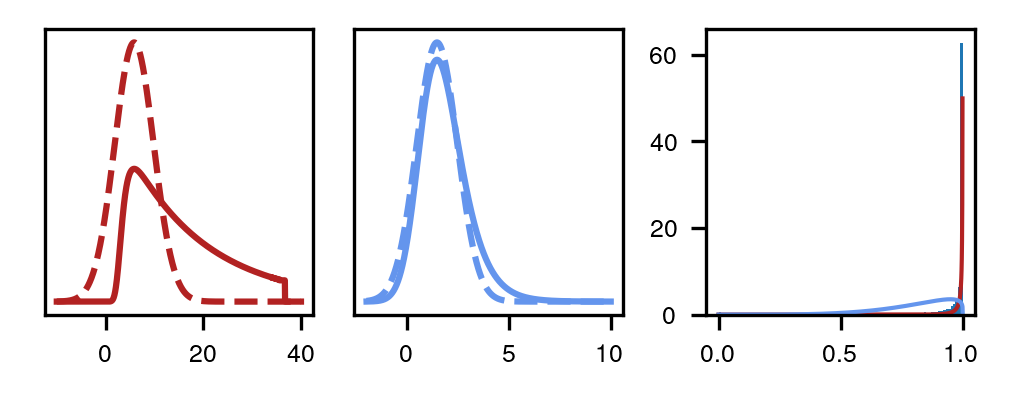

In [12]:
## real OOD example
plot_LB_limits_simplex(mu3, Sigma3, -10, 40, -2, 10, mode='beta', filename="delete.pdf")

# Comparing to the softmax Gaussian

In [13]:
from scipy.stats import multivariate_normal as mv_norm

In [14]:
def compare_approx(mu, Sigma):
    
    #apply the sum(y) = 0 correction
    mu_hat = correct_mu(mu, Sigma)
    Sigma_hat = correct_Sigma(mu, Sigma)
    K = len(mu)
    
    #APPLY YOUR CORRECTION HERE
    Sigma_diag_mean = np.diag(Sigma_hat).mean() / np.sqrt(K/2)
    mu_hat = mu_hat / np.sqrt(Sigma_diag_mean)
    Sigma_hat = Sigma_hat / Sigma_diag_mean
    alpha = get_alpha_from_Normal(mu_hat, Sigma_hat)
    #print("mu after correction: ", mu_hat)
    #print("Sigma after correction: ", Sigma_hat)
    
    
    norm_samples = mv_norm(mu, Sigma).rvs(10000)
    norm_samples_sm = np.exp(norm_samples) / np.exp(norm_samples).sum(1).reshape(-1, 1)
    print("softmax samples mean: ", norm_samples_sm.mean(0))
    print("mean from corrected Dirichlet: ", alpha / alpha.sum())

In [15]:
compare_approx(mu1, Sigma1)

softmax samples mean:  [0.5710 0.4290]
mean from corrected Dirichlet:  [0.6378 0.3622]


In [16]:
compare_approx(mu2, Sigma2)

softmax samples mean:  [0.2659 0.7341]
mean from corrected Dirichlet:  [0.1951 0.8049]


In [17]:
compare_approx(mu3, Sigma3)

softmax samples mean:  [0.9920 0.0080]
mean from corrected Dirichlet:  [0.9938 0.0062]


In [18]:
mu4 = np.array([7, 2, -7])
Sigma4 = np.array([[30, 0, 0],
                   [0, 2, 0],
                   [0, 0, 1]])

compare_approx(mu4, Sigma4)

softmax samples mean:  [0.8040 0.1959 0.0001]
mean from corrected Dirichlet:  [0.9090 0.0905 0.0005]


In [19]:
mu5 = np.array([7, 0, 2, 0, -7])
Sigma5 = 140 * np.eye(5)
compare_approx(mu5, Sigma5)

softmax samples mean:  [0.3762 0.1677 0.2208 0.1714 0.0639]
mean from corrected Dirichlet:  [0.2560 0.1898 0.2035 0.1898 0.1609]


In [20]:
### in dist MNIST diagonal
mu_M1 = np.array([ -3.6094,  -2.8937,   1.1239,   1.7301,  -9.0167,  -3.9072, -17.8319,
                 13.2881,  -5.2003,   0.8784])
Sigma_M1 = np.array([[ 9.1984,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, 0.0000,  0.0000],
        [ 0.0000, 19.1064,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, 0.0000,  0.0000],
        [ 0.0000,  0.0000,  3.7570,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, 0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  3.2656,  0.0000,  0.0000,  0.0000,  0.0000, 0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  8.3827,  0.0000,  0.0000,  0.0000, 0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  6.0570,  0.0000,  0.0000, 0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, 21.9312,  0.0000, 0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  2.3324, 0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, 4.4827,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, 0.0000,  3.0562]])

compare_approx(mu_M1, Sigma_M1)

softmax samples mean:  [0.0000 0.0008 0.0001 0.0002 0.0000 0.0000 0.0000 0.9989 0.0000 0.0001]
mean from corrected Dirichlet:  [0.0001 0.0003 0.0008 0.0012 0.0000 0.0001 0.0000 0.9968 0.0000 0.0007]


In [21]:
### OOD MNIST sample from KMNIST diagonal
mu_M2 = np.array([ -0.3258,  -2.6156,   2.0024, -10.2074,  -1.7162,  -0.9300,  -3.0700,
                  3.0261,  -1.1326,  -6.6048])
Sigma_M2 = np.array([[10.9447,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, 0.0000,  0.0000],
        [ 0.0000, 38.1201,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, 0.0000,  0.0000],
        [ 0.0000,  0.0000,  5.6068,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, 0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  5.0454,  0.0000,  0.0000,  0.0000,  0.0000, 0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  7.6814,  0.0000,  0.0000,  0.0000, 0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  4.9295,  0.0000,  0.0000, 0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, 12.1236,  0.0000, 0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  6.0272, 0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, 4.1253,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, 0.0000,  4.6678]])

compare_approx(mu_M2, Sigma_M2)

softmax samples mean:  [0.1064 0.1381 0.2335 0.0000 0.0384 0.0391 0.0308 0.3832 0.0302 0.0003]
mean from corrected Dirichlet:  [0.0652 0.1593 0.2069 0.0207 0.0387 0.0625 0.0227 0.3350 0.0651 0.0240]


In [22]:
### in dist MNIST kfac
mu_M3 = np.array([ -3.6094,  -2.8937,   1.1239,   1.7301,  -9.0167,  -3.9072, -17.8319,
         13.2881,  -5.2003,   0.8784])
Sigma_M3 = np.array([[42.6037, 40.4586, 40.5774, 40.5005, 40.5371, 40.5741, 40.8008, 40.5139, 40.6334, 40.5754],
                    [40.4586, 42.3545, 40.7232, 40.5542, 40.6854, 40.5083, 40.5141, 40.6926, 40.6774, 40.6066],
                    [40.5774, 40.7232, 41.9556, 40.7366, 40.6178, 40.5562, 40.4891, 40.7880, 40.7114, 40.6196],
                    [40.5005, 40.5542, 40.7366, 41.9227, 40.5880, 40.8414, 40.4990, 40.7278, 40.7166, 40.6885],
                    [40.5371, 40.6854, 40.6178, 40.5880, 41.8064, 40.5738, 40.6068, 40.7205, 40.6691, 40.9704],
                    [40.5741, 40.5083, 40.5562, 40.8414, 40.5738, 42.0326, 40.7329, 40.5634, 40.7450, 40.6472],
                    [40.8008, 40.5141, 40.4891, 40.4990, 40.6068, 40.7329, 42.4786, 40.4548, 40.6701, 40.5288],
                    [40.5139, 40.6926, 40.7880, 40.7278, 40.7205, 40.5634, 40.4548, 41.8525, 40.6419, 40.8200],
                    [40.6334, 40.6774, 40.7114, 40.7166, 40.6691, 40.7450, 40.6701, 40.6419, 41.5895, 40.7207],
                    [40.5754, 40.6066, 40.6196, 40.6885, 40.9704, 40.6472, 40.5288, 40.8200, 40.7207, 41.5984]])

compare_approx(mu_M3, Sigma_M3)

softmax samples mean:  [0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.9999 0.0000 0.0000]
mean from corrected Dirichlet:  [0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000]


In [23]:
### OOD MNIST sample from KMNIST kfac
mu_M4 = np.array([ -0.3258,  -2.6156,   2.0024, -10.2074,  -1.7162,  -0.9300,  -3.0700, 3.0261,  -1.1326,  -6.6048])
Sigma_M4 = np.array([[45.1095, 26.1054, 27.0449, 26.4079, 26.6924, 26.9655, 28.7031, 26.5338, 27.4766, 27.0231],
                    [26.1054, 43.1863, 28.1643, 26.7889, 27.8688, 26.4563, 26.5479, 27.9078, 27.8381, 27.1983],
                    [27.0449, 28.1643, 39.9264, 28.3120, 27.3064, 26.8079, 26.3263, 28.7393, 28.1347, 27.3000],
                    [26.4079, 26.7889, 28.3120, 39.6216, 27.0472, 29.2015, 26.3780, 28.2318, 28.1611, 27.9122],
                    [26.6924, 27.8688, 27.3064, 27.0472, 38.6031, 26.9539, 27.2805, 28.1500, 27.7546, 30.4056],
                    [26.9655, 26.4563, 26.8079, 29.2015, 26.9539, 40.5569, 28.2534, 26.8700, 28.4134, 27.5836],
                    [28.7031, 26.5479, 26.3263, 26.3780, 27.2804, 28.2534, 44.1292, 26.0523, 27.7793, 26.6122],
                    [26.5338, 27.9078, 28.7393, 28.2318, 28.1500, 26.8700, 26.0523, 39.0144, 27.5094, 29.0536],
                    [27.4766, 27.8381, 28.1347, 28.1611, 27.7546, 28.4134, 27.7793, 27.5094, 36.7683, 28.2269],
                    [27.0231, 27.1983, 27.3000, 27.9122, 30.4056, 27.5836, 26.6122, 29.0535, 28.2269, 36.7473]])

compare_approx(mu_M4, Sigma_M4)

softmax samples mean:  [0.1348 0.0447 0.2406 0.0001 0.0455 0.0851 0.0437 0.3547 0.0501 0.0008]
mean from corrected Dirichlet:  [0.0636 0.0461 0.1877 0.0421 0.0783 0.0765 0.0407 0.2958 0.1081 0.0611]


/home/marius/anaconda3/lib/python3.9/site-packages/scipy/stats/_multivariate.py:653: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)


In [24]:
### In dist example from CIFAR10 diag
mu_C1 = np.array([-0.7904, -0.9332, -1.2690, 10.5045, -1.5545,  0.2727, -1.2620, -1.6380,
                  -1.6235, -1.7063])
Sigma_C1 = np.array([[7.3171, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
                    [0.0000, 7.8437, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
                    [0.0000, 0.0000, 6.9209, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
                    [0.0000, 0.0000, 0.0000, 4.6104, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
                    [0.0000, 0.0000, 0.0000, 0.0000, 7.1798, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
                    [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 5.7733, 0.0000, 0.0000, 0.0000, 0.0000],
                    [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 7.2872, 0.0000, 0.0000, 0.0000],
                    [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 7.4371, 0.0000, 0.0000],
                    [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 7.6382, 0.0000],
                    [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 7.5489]])

compare_approx(mu_C1, Sigma_C1)

softmax samples mean:  [0.0021 0.0026 0.0012 0.9861 0.0011 0.0028 0.0014 0.0009 0.0008 0.0010]
mean from corrected Dirichlet:  [0.0056 0.0052 0.0057 0.9497 0.0054 0.0077 0.0054 0.0052 0.0051 0.0051]


In [25]:
### Out dist example from CIFAR10 SVHN diag
mu_C2 = np.array([ 2.7337, -1.1095, -1.9700,  1.3098, -4.0968,  4.4117,  1.1552, -0.2485,
        -2.0887, -0.0966])
Sigma_C2 = np.array([[4.5158, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
                    [0.0000, 5.1170, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
                    [0.0000, 0.0000, 4.7239, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
                    [0.0000, 0.0000, 0.0000, 3.6724, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
                    [0.0000, 0.0000, 0.0000, 0.0000, 4.9694, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
                    [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 3.7288, 0.0000, 0.0000, 0.0000, 0.0000],
                    [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 4.7160, 0.0000, 0.0000, 0.0000],
                    [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 4.8042, 0.0000, 0.0000],
                    [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 4.9789, 0.0000],
                    [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 4.8240]])

compare_approx(mu_C2, Sigma_C2)

softmax samples mean:  [0.2157 0.0191 0.0085 0.0806 0.0016 0.5152 0.0830 0.0327 0.0075 0.0361]
mean from corrected Dirichlet:  [0.1421 0.0358 0.0355 0.0863 0.0315 0.4826 0.0650 0.0432 0.0336 0.0444]


## Contourplot of scaling

Show that LB scales faster with mu and Sigma

In [26]:
# create values    
    
x_ = np.linspace(1, 10, 10)

alpha_values = []
alpha_values_corrected = []
for x in x_[::-1]:
    alpha_values_row = []
    alpha_values_corrected_row = []
    
    for y in x_:
        mu_ = np.array([x, -x])
        sigma_ = np.array([[y, 0],
                           [0, y]])
        mu_corrected = correct_mu(mu_, sigma_)
        sigma_corrected = correct_Sigma(mu_, sigma_)
        Sigma_diag_mean = np.diag(sigma_corrected).mean()
        mu_hat= mu_corrected / np.sqrt(Sigma_diag_mean)
        sigma_hat = sigma_corrected / Sigma_diag_mean
        
        #compute alphas
        #print(mu_, sigma_)
        alpha = get_alpha_from_Normal(mu_, sigma_)[0]
        #print(mu_hat, sigma_hat)
        alpha_corrected = get_alpha_from_Normal(mu_hat, sigma_hat)[0]
        #print("alpha corrected: ", alpha_corrected)
        
        alpha_values_row.append(alpha)
        alpha_values_corrected_row.append(alpha_corrected)
        
    alpha_values.append(alpha_values_row)
    alpha_values_corrected.append(alpha_values_corrected_row)
    

In [27]:
np.round(alpha_values, 1)

array([[121291299.1000, 60645649.6000, 40430433.0000, 30322824.8000,
        24258259.8000, 20215216.5000, 17327328.4000, 15161412.4000,
        13476811.0000, 12129129.9000],
       [16414992.5000, 8207496.3000, 5471664.2000, 4103748.1000,
        3282998.5000, 2735832.1000, 2344998.9000, 2051874.1000,
        1823888.1000, 1641499.3000],
       [2221527.9000, 1110763.9000, 740509.3000, 555382.0000,
        444305.6000, 370254.6000, 317361.1000, 277691.0000, 246836.4000,
        222152.8000],
       [300651.3000, 150325.7000, 100217.1000, 75162.8000, 60130.3000,
        50108.6000, 42950.2000, 37581.4000, 33405.7000, 30065.1000],
       [40688.9000, 20344.5000, 13563.0000, 10172.2000, 8137.8000,
        6781.5000, 5812.7000, 5086.1000, 4521.0000, 4068.9000],
       [5506.9000, 2753.4000, 1835.6000, 1376.7000, 1101.4000, 917.8000,
        786.7000, 688.4000, 611.9000, 550.7000],
       [745.5000, 372.7000, 248.5000, 186.4000, 149.1000, 124.2000,
        106.5000, 93.2000, 82.8000, 74.5

In [28]:
np.round(alpha_values_corrected, 1)

array([[480444179226.3000, 121291299.1000, 3089863.1000, 346570.7000,
        77871.8000, 25866.9000, 10983.8000, 5506.9000, 3108.4000,
        1916.2000],
       [28397011894.8000, 16414992.5000, 603586.4000, 84257.3000,
        21980.6000, 8152.2000, 3771.3000, 2026.0000, 1211.0000, 783.6000],
       [1678426588.4000, 2221527.9000, 117907.2000, 20484.6000,
        6204.5000, 2569.3000, 1295.0000, 745.5000, 471.9000, 320.5000],
       [99204656.8000, 300651.3000, 23032.7000, 4980.3000, 1751.5000,
        809.9000, 444.8000, 274.4000, 184.0000, 131.2000],
       [5863565.5000, 40688.9000, 4499.5000, 1211.0000, 494.6000,
        255.4000, 152.9000, 101.1000, 71.8000, 53.8000],
       [346570.7000, 5506.9000, 879.2000, 294.6000, 139.8000, 80.7000,
        52.7000, 37.4000, 28.1000, 22.1000],
       [20484.6000, 745.5000, 171.9000, 71.8000, 39.6000, 25.6000,
        18.2000, 13.9000, 11.1000, 9.2000],
       [1211.0000, 101.1000, 33.8000, 17.6000, 11.4000, 8.2000, 6.4000,
        5.3000, 

In [29]:
x_

array([1.0000, 2.0000, 3.0000, 4.0000, 5.0000, 6.0000, 7.0000, 8.0000,
       9.0000, 10.0000])

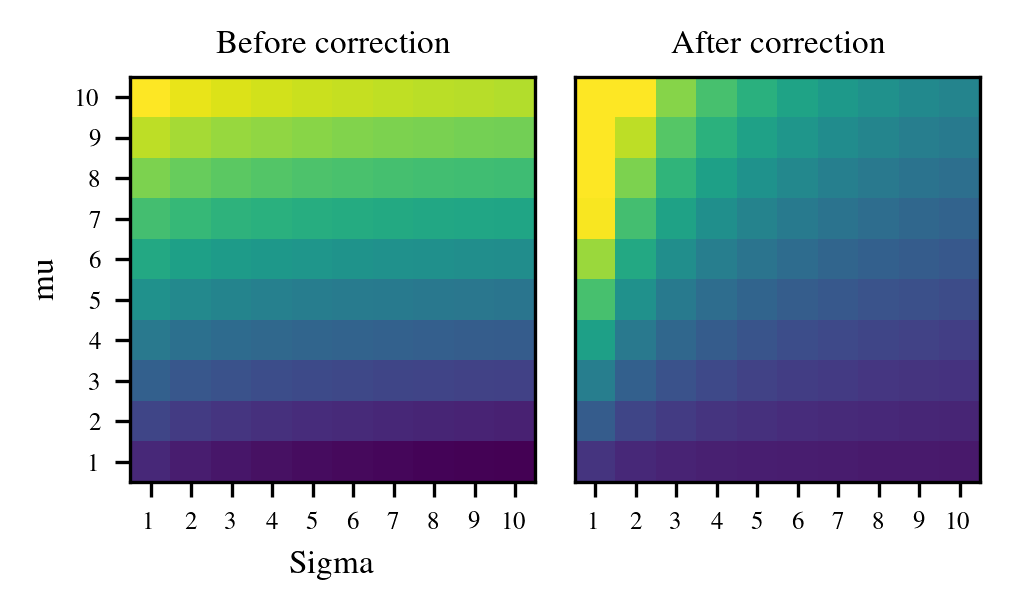

In [31]:
# plot these values

fig, ax = plt.subplots(1, 2, figsize=(figwidth, figheight), dpi=300)

alpha_values_log = np.log(alpha_values)
alpha_values_corrected_log = np.log(alpha_values_corrected)
v_min = np.min([np.min(alpha_values_log), np.min(alpha_values_corrected_log)])
v_max = np.min([np.max(alpha_values_log), np.max(alpha_values_corrected_log)])

ax[0].imshow(alpha_values_log, vmin=v_min, vmax=v_max)
ax[0].set_xlabel("Sigma")
ax[0].set_ylabel("mu")
ax[0].set_xticks(np.arange(len(x_)))
ax[0].set_xticklabels(np.arange(1, 1+len(x_)))
ax[0].set_yticks(np.arange(len(x_)))
ax[0].set_yticklabels(np.arange(1, 1+len(x_))[::-1])
ax[0].set_title("Before correction")

im = ax[1].imshow(np.log(alpha_values_corrected), vmin=v_min, vmax=v_max)
ax[1].set_xticks(np.arange(len(x_)))
ax[1].set_xticklabels(np.arange(1, 1+len(x_)))
ax[1].set_yticks([])
ax[1].set_yticklabels([])
ax[1].set_title("After correction")

#plt.colorbar(im)

plt.savefig("figures/correction_contour.pdf")
plt.show();